## 1. Let us use f (x) = 1.44/x2 + 0.24x to generate six data points:
(0.25, 23.1), (1.0, 1.68), (1.5, 1.0), (2.0, 0.84), (2.4, 0.826), and (5.0, 1.2576)
Fit least-squares polynomials, P2 (x), P3 (x), P4 (x), and P5 (x) to the above data-points
and plot the results.

In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [1]:
# Given data points
data = {
    0.25: 23.1,
    1.0: 1.68,
    1.5: 1.0,
    2.0: 0.84,
    2.4: 0.826,
    5.0: 1.2576
}


In [4]:
# Function to perform Gaussian elimination
def gaussian_elimination(A, B):
    n = len(B)

    # Augment the matrix A with the vector B
    augmented_matrix = np.column_stack([A, B])

    # Forward elimination
    for i in range(n):
        pivot_row = augmented_matrix[i, :]
        for j in range(i + 1, n):
            factor = augmented_matrix[j, i] / pivot_row[i]
            augmented_matrix[j, :] -= factor * pivot_row

    # Backward substitution
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = augmented_matrix[i, -1] / augmented_matrix[i, i]
        for j in range(i - 1, -1, -1):
            augmented_matrix[j, -1] -= augmented_matrix[j, i] * x[i]

    return x

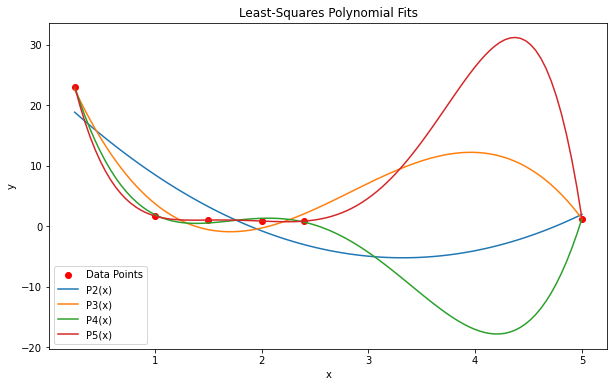

In [5]:
# Function to generate the Vandermonde matrix for given x values and degree
def vandermonde_matrix(x_values, degree):
    n = len(x_values)
    return np.column_stack([x_values**i for i in range(degree + 1)])

# Fit least-squares polynomial and return coefficients
def least_squares_fit(x_values, y_values, degree):
    A = vandermonde_matrix(x_values, degree)
    B = y_values
    coefficients = gaussian_elimination(A.T @ A, A.T @ B)
    return coefficients

# Given function
def f(x):
    return 1.44 / x**2 + 0.24 * x

# Generate data points
x_data = np.array(list(data.keys()))
y_data = np.array(list(data.values()))

# Polynomial degrees to fit
degrees = [2, 3, 4, 5]

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, label='Data Points', color='red')

for degree in degrees:
    # Fit the polynomial
    coefficients = least_squares_fit(x_data, y_data, degree)

    # Generate fitted polynomial values
    x_range = np.linspace(min(x_data), max(x_data), 100)
    y_fit = np.polyval(np.flip(coefficients), x_range)

    # Plot the fitted polynomial
    plt.plot(x_range, y_fit, label=f'P{degree}(x)')

plt.title('Least-Squares Polynomial Fits')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## 2. Write a program to construct and evaluate a clamped cubic spline interpolation S(x) for
the N + 1 data points {(xk , yk )}N
k=0 .
Use the above program to find the natural cubic spline that passes through (0,0.0), (1,
0.5), (2, 2.0), and (3, 1.5) with free boundary conditions S ′′ (0) = 0.2 and S ′′ (3) = −1.

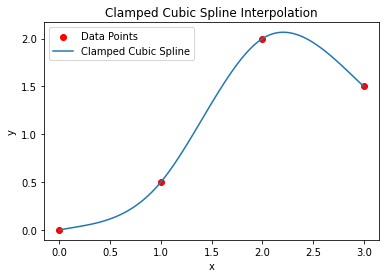

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Function to perform Gaussian elimination for tridiagonal systems
def tridiagonal_gaussian_elimination(A, B):
    n = len(B)

    # Forward elimination
    for i in range(1, n):
        factor = A[i, i-1] / A[i-1, i-1]
        A[i, :] -= factor * A[i-1, :]
        B[i] -= factor * B[i-1]

    # Backward substitution
    x = np.zeros(n)
    x[-1] = B[-1] / A[-1, -1]
    for i in range(n - 2, -1, -1):
        x[i] = (B[i] - A[i, i+1] * x[i+1]) / A[i, i]

    return x

# Function to construct a clamped cubic spline interpolation
def clamped_cubic_spline(x_values, y_values, d0, dn):
    n = len(x_values) - 1
    h = np.diff(x_values)
    
    # Construct the tridiagonal system
    A = np.zeros((n+1, n+1))
    B = np.zeros(n+1)
    
    A[0, 0] = 2 * h[0]
    A[0, 1] = h[0]
    B[0] = 6 / h[0] * (y_values[1] - y_values[0] - d0 * h[0])

    for i in range(1, n):
        A[i, i-1] = h[i-1]
        A[i, i] = 2 * (h[i-1] + h[i])
        A[i, i+1] = h[i]
        B[i] = 6 / h[i] * (y_values[i+1] - y_values[i] - y_values[i] + y_values[i-1])

    A[n, n-1] = h[n-1]
    A[n, n] = 2 * h[n-1]
    B[n] = 6 / h[n-1] * (dn * h[n-1] - (y_values[n] - y_values[n-1]))

    # Solve the tridiagonal system for the second derivatives
    second_derivatives = tridiagonal_gaussian_elimination(A, B)

    # Calculate the coefficients for each cubic spline
    coefficients = np.zeros((n, 4))
    for i in range(n):
        a = y_values[i]
        b = (y_values[i+1] - y_values[i]) / h[i] - h[i] * (2 * second_derivatives[i] + second_derivatives[i+1]) / 6
        c = second_derivatives[i] / 2
        d = (second_derivatives[i+1] - second_derivatives[i]) / (6 * h[i])
        coefficients[i, :] = np.array([a, b, c, d])

    return coefficients

# Function to evaluate the clamped cubic spline at a given x value
def evaluate_clamped_cubic_spline(x, x_values, coefficients):
    n = len(x_values) - 1
    for i in range(n):
        if x_values[i] <= x <= x_values[i+1]:
            h = x_values[i+1] - x_values[i]
            a, b, c, d = coefficients[i, :]
            return a + b * (x - x_values[i]) + c * (x - x_values[i])**2 + d * (x - x_values[i])**3

# Given data points
x_data = np.array([0, 1, 2, 3])
y_data = np.array([0.0, 0.5, 2.0, 1.5])

# Given boundary conditions
d0 = 0.2
dn = -1.0

# Construct the clamped cubic spline
coefficients = clamped_cubic_spline(x_data, y_data, d0, dn)

# Evaluate the spline on a finer grid for plotting
x_range = np.linspace(min(x_data), max(x_data), 100)
y_spline = [evaluate_clamped_cubic_spline(x, x_data, coefficients) for x in x_range]

# Plot the clamped cubic spline
plt.scatter(x_data, y_data, label='Data Points', color='red')
plt.plot(x_range, y_spline, label='Clamped Cubic Spline')
plt.title('Clamped Cubic Spline Interpolation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


## 3. Write a program to construct and evaluate a natural cubic spline interpolation S(x) for
the N + 1 data points {(xk , yk )}N
k=0 .
Use the above program to find the natural cubic spline that passes through (0,0.0), (1,
0.5), (2, 2.0), and (3, 1.5) with free boundary conditions S ′′ (0) = 0 and S ′′ (3) = 0.

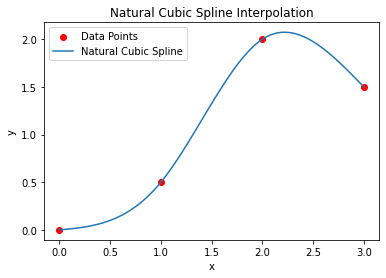

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Function to perform Gaussian elimination for tridiagonal systems
def tridiagonal_gaussian_elimination(A, B):
    n = len(B)

    # Forward elimination
    for i in range(1, n):
        factor = A[i, i-1] / A[i-1, i-1]
        A[i, :] -= factor * A[i-1, :]
        B[i] -= factor * B[i-1]

    # Backward substitution
    x = np.zeros(n)
    x[-1] = B[-1] / A[-1, -1]
    for i in range(n - 2, -1, -1):
        x[i] = (B[i] - A[i, i+1] * x[i+1]) / A[i, i]

    return x

# Function to construct a natural cubic spline interpolation
def natural_cubic_spline(x_values, y_values):
    n = len(x_values) - 1
    h = np.diff(x_values)
    
    # Construct the tridiagonal system
    A = np.zeros((n+1, n+1))
    B = np.zeros(n+1)
    
    A[0, 0] = 1
    A[n, n] = 1

    for i in range(1, n):
        A[i, i-1] = h[i-1]
        A[i, i] = 2 * (h[i-1] + h[i])
        A[i, i+1] = h[i]
        B[i] = 6 / h[i] * (y_values[i+1] - y_values[i] - y_values[i] + y_values[i-1])

    # Solve the tridiagonal system for the second derivatives
    second_derivatives = tridiagonal_gaussian_elimination(A, B)

    # Calculate the coefficients for each cubic spline
    coefficients = np.zeros((n, 4))
    for i in range(n):
        a = y_values[i]
        b = (y_values[i+1] - y_values[i]) / h[i] - h[i] * (2 * second_derivatives[i] + second_derivatives[i+1]) / 6
        c = second_derivatives[i] / 2
        d = (second_derivatives[i+1] - second_derivatives[i]) / (6 * h[i])
        coefficients[i, :] = np.array([a, b, c, d])

    return coefficients

# Function to evaluate the natural cubic spline at a given x value
def evaluate_natural_cubic_spline(x, x_values, coefficients):
    n = len(x_values) - 1
    for i in range(n):
        if x_values[i] <= x <= x_values[i+1]:
            h = x_values[i+1] - x_values[i]
            a, b, c, d = coefficients[i, :]
            return a + b * (x - x_values[i]) + c * (x - x_values[i])**2 + d * (x - x_values[i])**3

# Given data points
x_data = np.array([0, 1, 2, 3])
y_data = np.array([0.0, 0.5, 2.0, 1.5])

# Construct the natural cubic spline
coefficients = natural_cubic_spline(x_data, y_data)

# Evaluate the spline on a finer grid for plotting
x_range = np.linspace(min(x_data), max(x_data), 100)
y_spline = [evaluate_natural_cubic_spline(x, x_data, coefficients) for x in x_range]

# Plot the natural cubic spline
plt.scatter(x_data, y_data, label='Data Points', color='red')
plt.plot(x_range, y_spline, label='Natural Cubic Spline')
plt.title('Natural Cubic Spline Interpolation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
